In [5]:
from PIL import Image, ImageSequence
import numpy as np
image_tiff = Image.open("/home/marco/Base_Patrones/Celulas/datos_tarea2/segmentacion_referencia.tif")

images_ref = []
for i, page in enumerate(ImageSequence.Iterator(image_tiff)):
    images_ref.append(np.array(page))
    
image_tiff = Image.open("/home/marco/Base_Patrones/Celulas/datos_tarea2/raw.tif")

images_raw=[]
for i, page in enumerate(ImageSequence.Iterator(image_tiff)):
    images_raw.append(np.array(page))

In [2]:
import numpy as np
import cv2

def get_carec(Imagen):
    kernel = np.array([[1/9,1/9,1/9],
                    [1/9,1/9,1/9],
                    [1/9,1/9,1/9]
                       ], np.float32)
    promedio = cv2.filter2D(Imagen, -1, kernel)
    laplacian = cv2.Laplacian(Imagen,cv2.CV_64F)
    sobelx = cv2.Sobel(Imagen,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(Imagen,cv2.CV_64F,0,1,ksize=5)
    
    return promedio, laplacian, sobelx, sobely

def trans_class(imagen):
    new_img=[]
    for vec in imagen:
        im = np.where(vec==255,1,vec)
        new_img.append(im)
    return np.array(new_img)

In [3]:
promedio, laplacian, sobelx, sobely = get_carec(images_raw[40])

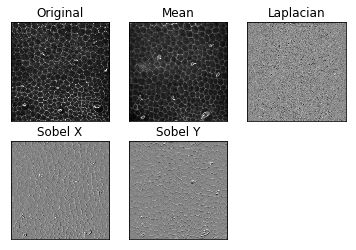

In [4]:
from matplotlib import pyplot as plt

plt.subplot(2,3,1),plt.imshow(images_raw[2],cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(promedio,cmap = 'gray')
plt.title('Mean'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,4),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,5),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

In [6]:
def constru_BD(images_ref,images_raw,index1,index2):
    ind_imag=index1
    fila_promedio = np.array([])
    fila_laplacian = np.array([])
    fila_sobelx = np.array([])
    fila_sobely = np.array([])
    fila_target = np.array([])
    for img in images_raw[index1:index2]:
            
            promedio, laplacian, sobelx, sobely = get_carec(img)
            target = trans_class(images_ref[ind_imag])
            fila_promedio=np.concatenate((fila_promedio,promedio.flatten()),axis=None)
            fila_laplacian=np.concatenate((fila_laplacian,laplacian.flatten()),axis=None)
            fila_sobelx=np.concatenate((fila_sobelx,sobelx.flatten()),axis=None)
            fila_sobely=np.concatenate((fila_sobely,sobely.flatten()),axis=None)
            fila_target=np.concatenate((fila_target,target.flatten()),axis=None)
            ind_imag=ind_imag+1
    matrix = []
    matrix.append(fila_promedio)
    matrix.append(fila_laplacian)
    matrix.append(fila_sobelx)
    matrix.append(fila_sobely)
    matrix.append(fila_target)
    return np.array(matrix)


In [93]:
matrix = constru_BD(images_ref,images_raw,0,25)
matrix = np.transpose(matrix)
matrix1=[]
matrix0=[]
for vec in matrix:
    if vec[4]==0:
        matrix0.append(vec)
    else:
        matrix1.append(vec)
matrix1 = np.array(matrix1)
matrix0 = np.array(matrix0) 
indices = np.arange(len(matrix1))
rnd_indices = np.random.choice(indices, size=len(matrix0))

xor_data = matrix1[rnd_indices]


In [94]:
print(xor_data.shape,matrix0.shape)

(1260442, 5) (1260442, 5)


In [95]:
matrix_bala= np.asmatrix(np.concatenate((xor_data,matrix0),axis=0))

X_data = matrix_bala[:,[0,1,2,3]]
Y_data =  matrix_bala[:,[4]]

In [73]:
print(X_data.getA())

[[  41.   -8.  -78. -134.]
 [  61.   33. -617. -413.]
 [  54.   25. -816. -530.]
 ...
 [  36.    8.  388.    0.]
 [  41.   20.  456.    0.]
 [  40.  -82.    0.    0.]]


In [70]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,max_depth=10)


/home/marco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [96]:
clf.fit(X_data,Y_data) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [97]:
matrix1 = constru_BD(images_ref,images_raw,50,51)
matrix1= np.transpose(matrix1)
X_data1 = matrix1[:,[0,1,2,3]]
Y_data1 =  matrix1[:,[4]]
print(X_data1)

[[  67.  -28.    0.    0.]
 [  66.   55. -524.    0.]
 [  60.   -5. -636.    0.]
 ...
 [  53.   16. 2346.    0.]
 [  81.   -7. 2684.    0.]
 [  88. -108.    0.    0.]]


In [98]:
import warnings; warnings.simplefilter('ignore')
def evaluar_fores(matrix):
    resp = []
    for vec in matrix:
        resp.append(clf.predict(vec))
    return np.array(resp)


In [99]:
preic = evaluar_fores(X_data1)

In [100]:
predic =[]
for x in preic:
    predic.append(x[0])

predic = np.array(predic)



In [101]:
def borde_marcador(imagen,predic):
    iindex=0
    resp=[]
    count =0
    for x in predic:
        if x[0] ==0:
            #count=count+1
            resp.append(230)
        else:
            resp.append(imagen[iindex])
        iindex=iindex+1
    return np.array(resp), count

In [102]:
resp,count = borde_marcador(images_raw[4].flatten(),preic)
resp = resp.reshape(512,512)
print(count)

0


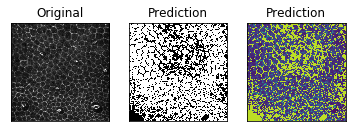

In [103]:
plt.subplot(1,3,1),plt.imshow(images_raw[4],cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(predic.reshape(512,512),cmap = 'gray')
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(resp)
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.show()

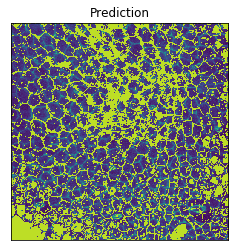

In [104]:
plt.imshow(resp)
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.show()

In [84]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7)


In [105]:
knn.fit(X_data,Y_data) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [86]:
import warnings; warnings.simplefilter('ignore')
def evaluar_knn(matrix):
    resp = []
    for vec in matrix:
        resp.append(knn.predict(vec))
    return np.array(resp)

In [106]:
preic = evaluar_knn(X_data1)

In [107]:
predic =[]
for x in preic:
    predic.append(x[0])

predic = np.array(predic)



In [108]:
resp,count = borde_marcador(images_raw[4].flatten(),preic)
resp = resp.reshape(512,512)
print(count)

0


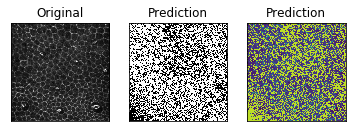

In [109]:
plt.subplot(1,3,1),plt.imshow(images_raw[4],cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(predic.reshape(512,512),cmap = 'gray')
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(resp)
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.show()

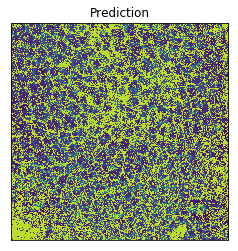

In [110]:
plt.imshow(resp)
plt.title('Prediction'), plt.xticks([]), plt.yticks([])
plt.show()